<a href="https://colab.research.google.com/github/akashsingh918/prediction-model-for-bioethanol-production/blob/main/BE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# run this first only after you have saved the synthetic_data.csv file from my github account
from google.colab import files
uploaded = files.upload()


Saving synthetic_data.csv to synthetic_data (1).csv


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Test MSE: 60.4424
R² Glucose: 0.04, R² Xylose: 0.64


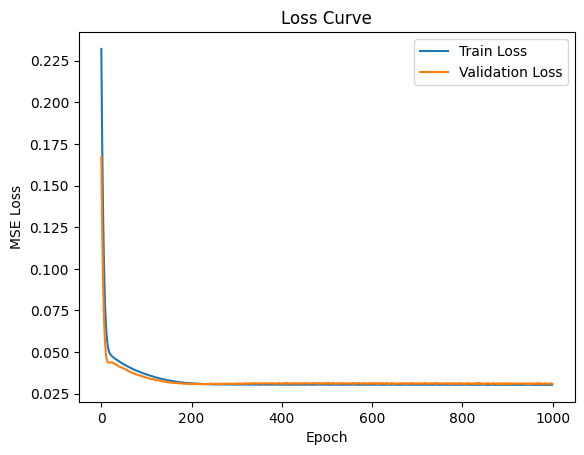

In [5]:
# MODEL 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
df = pd.read_csv('synthetic_data.csv')
X = df[['biomass_loading', 'particle_size', 'time']].values
y = df[['glucose', 'xylose']].values

# === Step 2: Normalize ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# === Step 3: Split Data ===
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === Step 4: Build ANN ===
model = Sequential()
model.add(Input(shape=(3,)))
model.add(Dense(8, activation='sigmoid'))  # logsig ≈ sigmoid
model.add(Dense(2, activation='linear'))  # purelin ≈ linear

# === Step 5: Compile & Train ===
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=0)

# === Step 6: Evaluate ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2_glucose = r2_score(y_true[:, 0], y_pred[:, 0])
r2_xylose = r2_score(y_true[:, 1], y_pred[:, 1])

print(f"Test MSE: {mse:.4f}")
print(f"R² Glucose: {r2_glucose:.2f}, R² Xylose: {r2_xylose:.2f}")

# === Step 7: Plot ===
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Test MSE: 10.0963
R² Glucose: 0.8606
R² Xylose: 0.8646


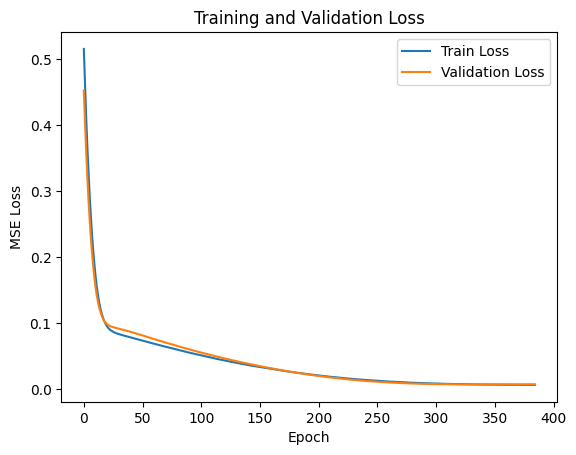

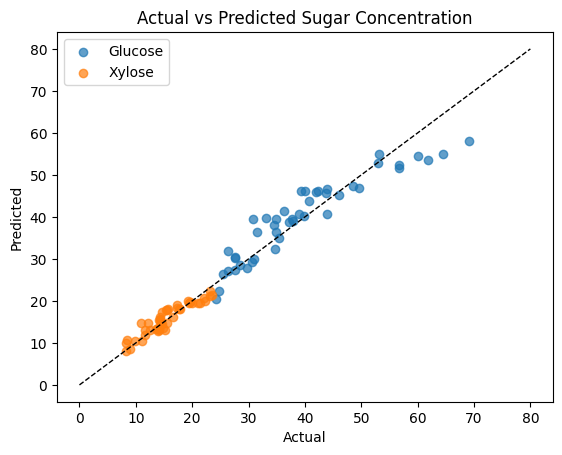

In [1]:
# Model 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# ==== STEP 1: Define sigmoid-based sugar growth ====
def generate_sugar(time, min_val, max_val, noise_std=1.5):
    midpoint = 28
    scale = 8
    base = min_val + (max_val - min_val) / (1 + np.exp(-(time - midpoint) / scale))
    noise = np.random.normal(0, noise_std)
    return np.clip(base + noise, min_val, max_val)

# ==== STEP 2: Define synthetic conditions ====
particle_size_codes = {"<0.5 mm": 0, "0.5 - 1.0 mm": 1, ">1.0 mm": 2, "Mixed": 3}
conditions = [
    [10, "<0.5 mm", (21.1, 41.7), (7.2, 15.9)],
    [10, "0.5 - 1.0 mm", (21.4, 43.4), (7.5, 15.5)],
    [10, ">1.0 mm", (19.9, 49.3), (7.06, 15.3)],
    [15, "<0.5 mm", (26.4, 55.3), (12.6, 21.05)],
    [15, "0.5 - 1.0 mm", (23.4, 60.1), (11.6, 22.3)],
    [15, ">1.0 mm", (24.7, 61.6), (13.15, 22.8)],
    [18, "<0.5 mm", (27.9, 61.4), (12.3, 24.2)],
    [18, "0.5 - 1.0 mm", (26.6, 67.0), (14.7, 25.01)],
    [18, ">1.0 mm", (26.5, 73.4), (14.2, 24.9)],
    [10, "Mixed", (20.3, 44.7), (7.1, 12.9)],
    [15, "Mixed", (25.4, 60.1), (12.9, 21.8)],
    [18, "Mixed", (26.0, 71.6), (15.01, 24.3)]
]
time_range = (4, 48)
samples_per_condition = 25
np.random.seed(42)

# ==== STEP 3: Generate synthetic dataset ====
synthetic_data = []
for biomass, size_label, glucose_range, xylose_range in conditions:
    size_code = particle_size_codes[size_label]
    for _ in range(samples_per_condition):
        time = np.random.uniform(*time_range)
        glucose = generate_sugar(time, *glucose_range, noise_std=2)
        xylose = generate_sugar(time, *xylose_range, noise_std=1)
        synthetic_data.append([biomass, size_code, time, glucose, xylose])

df = pd.DataFrame(synthetic_data, columns=['biomass_loading', 'particle_size', 'time', 'glucose', 'xylose'])

# Optional: Save CSV
# df.to_csv('synthetic_data.csv', index=False)

# ==== STEP 4: Prepare data ====
X = df[['biomass_loading', 'particle_size', 'time']].values
y = df[['glucose', 'xylose']].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ==== STEP 5: Define and train ANN ====
model = Sequential()
model.add(Dense(8, input_dim=3, activation='sigmoid'))  # matches paper: logsig
model.add(Dense(2, activation='linear'))  # matches paper: purelin

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stop])

# ==== STEP 6: Evaluate ====
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2_glucose = r2_score(y_true[:, 0], y_pred[:, 0])
r2_xylose = r2_score(y_true[:, 1], y_pred[:, 1])

print(f"\nTest MSE: {mse:.4f}")
print(f"R² Glucose: {r2_glucose:.4f}")
print(f"R² Xylose: {r2_xylose:.4f}")

# ==== STEP 7: Plot Loss ====
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# ==== STEP 8: Optional: Visual Validation ====
plt.figure()
plt.scatter(y_true[:, 0], y_pred[:, 0], label="Glucose", alpha=0.7)
plt.scatter(y_true[:, 1], y_pred[:, 1], label="Xylose", alpha=0.7)
plt.plot([0, 80], [0, 80], 'k--', lw=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Sugar Concentration")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Test MSE: 4.8213
R² Glucose: 0.9327
R² Xylose: 0.9406


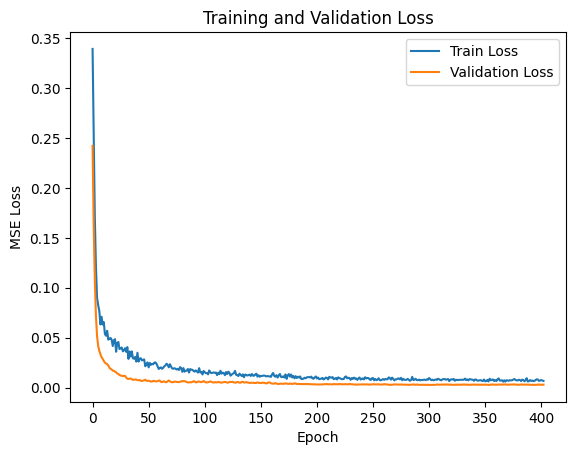

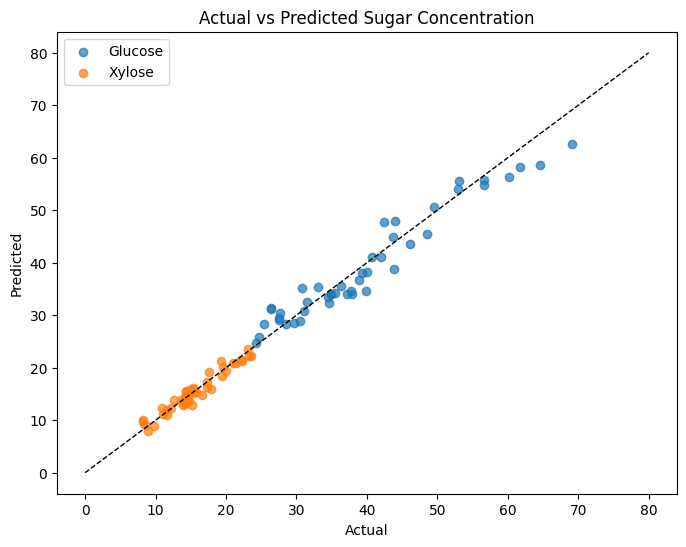

In [7]:
# MODEL 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ==== Data Generation (same as your revised model) ====
def generate_sugar(time, min_val, max_val, noise_std=1.5):
    midpoint = 28
    scale = 8
    base = min_val + (max_val - min_val) / (1 + np.exp(-(time - midpoint) / scale))
    noise = np.random.normal(0, noise_std)
    return np.clip(base + noise, min_val, max_val)

particle_size_labels = ["<0.5 mm", "0.5 - 1.0 mm", ">1.0 mm", "Mixed"]
conditions = [
    [10, "<0.5 mm", (21.1, 41.7), (7.2, 15.9)],
    [10, "0.5 - 1.0 mm", (21.4, 43.4), (7.5, 15.5)],
    [10, ">1.0 mm", (19.9, 49.3), (7.06, 15.3)],
    [15, "<0.5 mm", (26.4, 55.3), (12.6, 21.05)],
    [15, "0.5 - 1.0 mm", (23.4, 60.1), (11.6, 22.3)],
    [15, ">1.0 mm", (24.7, 61.6), (13.15, 22.8)],
    [18, "<0.5 mm", (27.9, 61.4), (12.3, 24.2)],
    [18, "0.5 - 1.0 mm", (26.6, 67.0), (14.7, 25.01)],
    [18, ">1.0 mm", (26.5, 73.4), (14.2, 24.9)],
    [10, "Mixed", (20.3, 44.7), (7.1, 12.9)],
    [15, "Mixed", (25.4, 60.1), (12.9, 21.8)],
    [18, "Mixed", (26.0, 71.6), (15.01, 24.3)]
]
time_range = (4, 48)
samples_per_condition = 25
np.random.seed(42)

synthetic_data = []
for biomass, size_label, glucose_range, xylose_range in conditions:
    for _ in range(samples_per_condition):
        time = np.random.uniform(*time_range)
        glucose = generate_sugar(time, *glucose_range, noise_std=2)
        xylose = generate_sugar(time, *xylose_range, noise_std=1)
        synthetic_data.append([biomass, size_label, time, glucose, xylose])

df = pd.DataFrame(synthetic_data, columns=['biomass_loading', 'particle_size', 'time', 'glucose', 'xylose'])

# ==== Feature preprocessing ====

# One-hot encode particle size
onehot = OneHotEncoder(sparse_output=False)
particle_size_encoded = onehot.fit_transform(df[['particle_size']])

# Prepare feature matrix
X = np.hstack([
    df[['biomass_loading', 'time']].values,
    particle_size_encoded
])

y = df[['glucose', 'xylose']].values

# Scale features and targets
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ==== Model Definition ====
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# ==== Training ====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop]
)

# ==== Evaluation ====
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2_glucose = r2_score(y_true[:, 0], y_pred[:, 0])
r2_xylose = r2_score(y_true[:, 1], y_pred[:, 1])

print(f"\nTest MSE: {mse:.4f}")
print(f"R² Glucose: {r2_glucose:.4f}")
print(f"R² Xylose: {r2_xylose:.4f}")

# ==== Plot Loss ====
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# ==== Visual Validation ====
plt.figure(figsize=(8,6))
plt.scatter(y_true[:, 0], y_pred[:, 0], label="Glucose", alpha=0.7)
plt.scatter(y_true[:, 1], y_pred[:, 1], label="Xylose", alpha=0.7)
plt.plot([0, 80], [0, 80], 'k--', lw=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Sugar Concentration")
plt.legend()
plt.show()


Epoch 1/1500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 2.1174 - val_loss: 0.1676
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5906 - val_loss: 0.1502
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5422 - val_loss: 0.1328
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4330 - val_loss: 0.1161
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2741 - val_loss: 0.1034
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0661 - val_loss: 0.0949
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0341 - val_loss: 0.0900
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0504 - val_loss: 0.0876
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0340 - val_loss: 0.0853
Epoch 10/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7403 - val_loss: 0.0807
Epoch 11/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7308 - val_loss: 0.0770
Epoch 12/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8389 - val_lo

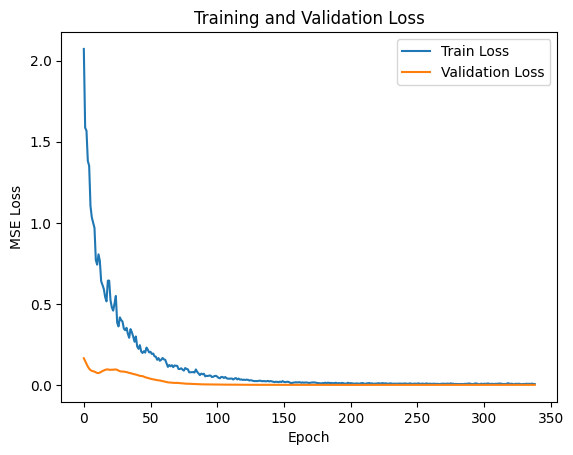

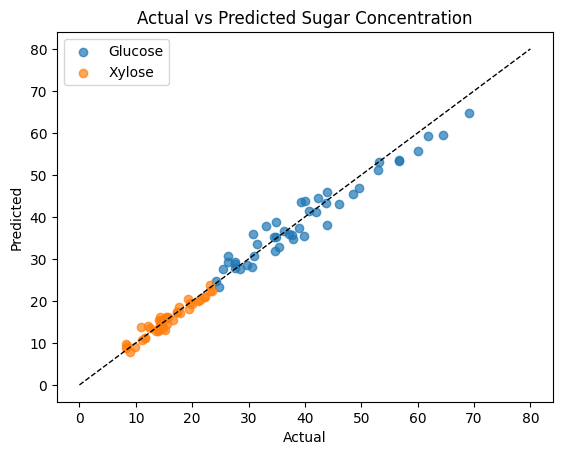

In [8]:
# MODEL 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==== STEP 1: Define sigmoid-based sugar growth ====
def generate_sugar(time, min_val, max_val, noise_std=1.5):
    midpoint = 28
    scale = 8
    base = min_val + (max_val - min_val) / (1 + np.exp(-(time - midpoint) / scale))
    noise = np.random.normal(0, noise_std)
    return np.clip(base + noise, min_val, max_val)

# ==== STEP 2: Define synthetic conditions ====
particle_size_codes = {"<0.5 mm": 0, "0.5 - 1.0 mm": 1, ">1.0 mm": 2, "Mixed": 3}
conditions = [
    [10, "<0.5 mm", (21.1, 41.7), (7.2, 15.9)],
    [10, "0.5 - 1.0 mm", (21.4, 43.4), (7.5, 15.5)],
    [10, ">1.0 mm", (19.9, 49.3), (7.06, 15.3)],
    [15, "<0.5 mm", (26.4, 55.3), (12.6, 21.05)],
    [15, "0.5 - 1.0 mm", (23.4, 60.1), (11.6, 22.3)],
    [15, ">1.0 mm", (24.7, 61.6), (13.15, 22.8)],
    [18, "<0.5 mm", (27.9, 61.4), (12.3, 24.2)],
    [18, "0.5 - 1.0 mm", (26.6, 67.0), (14.7, 25.01)],
    [18, ">1.0 mm", (26.5, 73.4), (14.2, 24.9)],
    [10, "Mixed", (20.3, 44.7), (7.1, 12.9)],
    [15, "Mixed", (25.4, 60.1), (12.9, 21.8)],
    [18, "Mixed", (26.0, 71.6), (15.01, 24.3)]
]
time_range = (4, 48)
samples_per_condition = 25
np.random.seed(42)

# ==== STEP 3: Generate synthetic dataset ====
synthetic_data = []
for biomass, size_label, glucose_range, xylose_range in conditions:
    size_code = particle_size_codes[size_label]
    for _ in range(samples_per_condition):
        time = np.random.uniform(*time_range)
        glucose = generate_sugar(time, *glucose_range, noise_std=2)
        xylose = generate_sugar(time, *xylose_range, noise_std=1)
        synthetic_data.append([biomass, size_code, time, glucose, xylose])

df = pd.DataFrame(synthetic_data, columns=['biomass_loading', 'particle_size', 'time', 'glucose', 'xylose'])

# ==== STEP 4: Prepare data ====
X = df[['biomass_loading', 'particle_size', 'time']].values
y = df[['glucose', 'xylose']].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ==== STEP 5: Define and train improved ANN ====
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(2, activation='linear')  # output layer for glucose and xylose
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=1500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ==== STEP 6: Evaluate ====
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2_glucose = r2_score(y_true[:, 0], y_pred[:, 0])
r2_xylose = r2_score(y_true[:, 1], y_pred[:, 1])

print(f"\nTest MSE: {mse:.4f}")
print(f"R² Glucose: {r2_glucose:.4f}")
print(f"R² Xylose: {r2_xylose:.4f}")

# ==== STEP 7: Plot Loss ====
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# ==== STEP 8: Visual Validation ====
plt.figure()
plt.scatter(y_true[:, 0], y_pred[:, 0], label="Glucose", alpha=0.7)
plt.scatter(y_true[:, 1], y_pred[:, 1], label="Xylose", alpha=0.7)
plt.plot([0, 80], [0, 80], 'k--', lw=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Sugar Concentration")
plt.legend()
plt.show()
